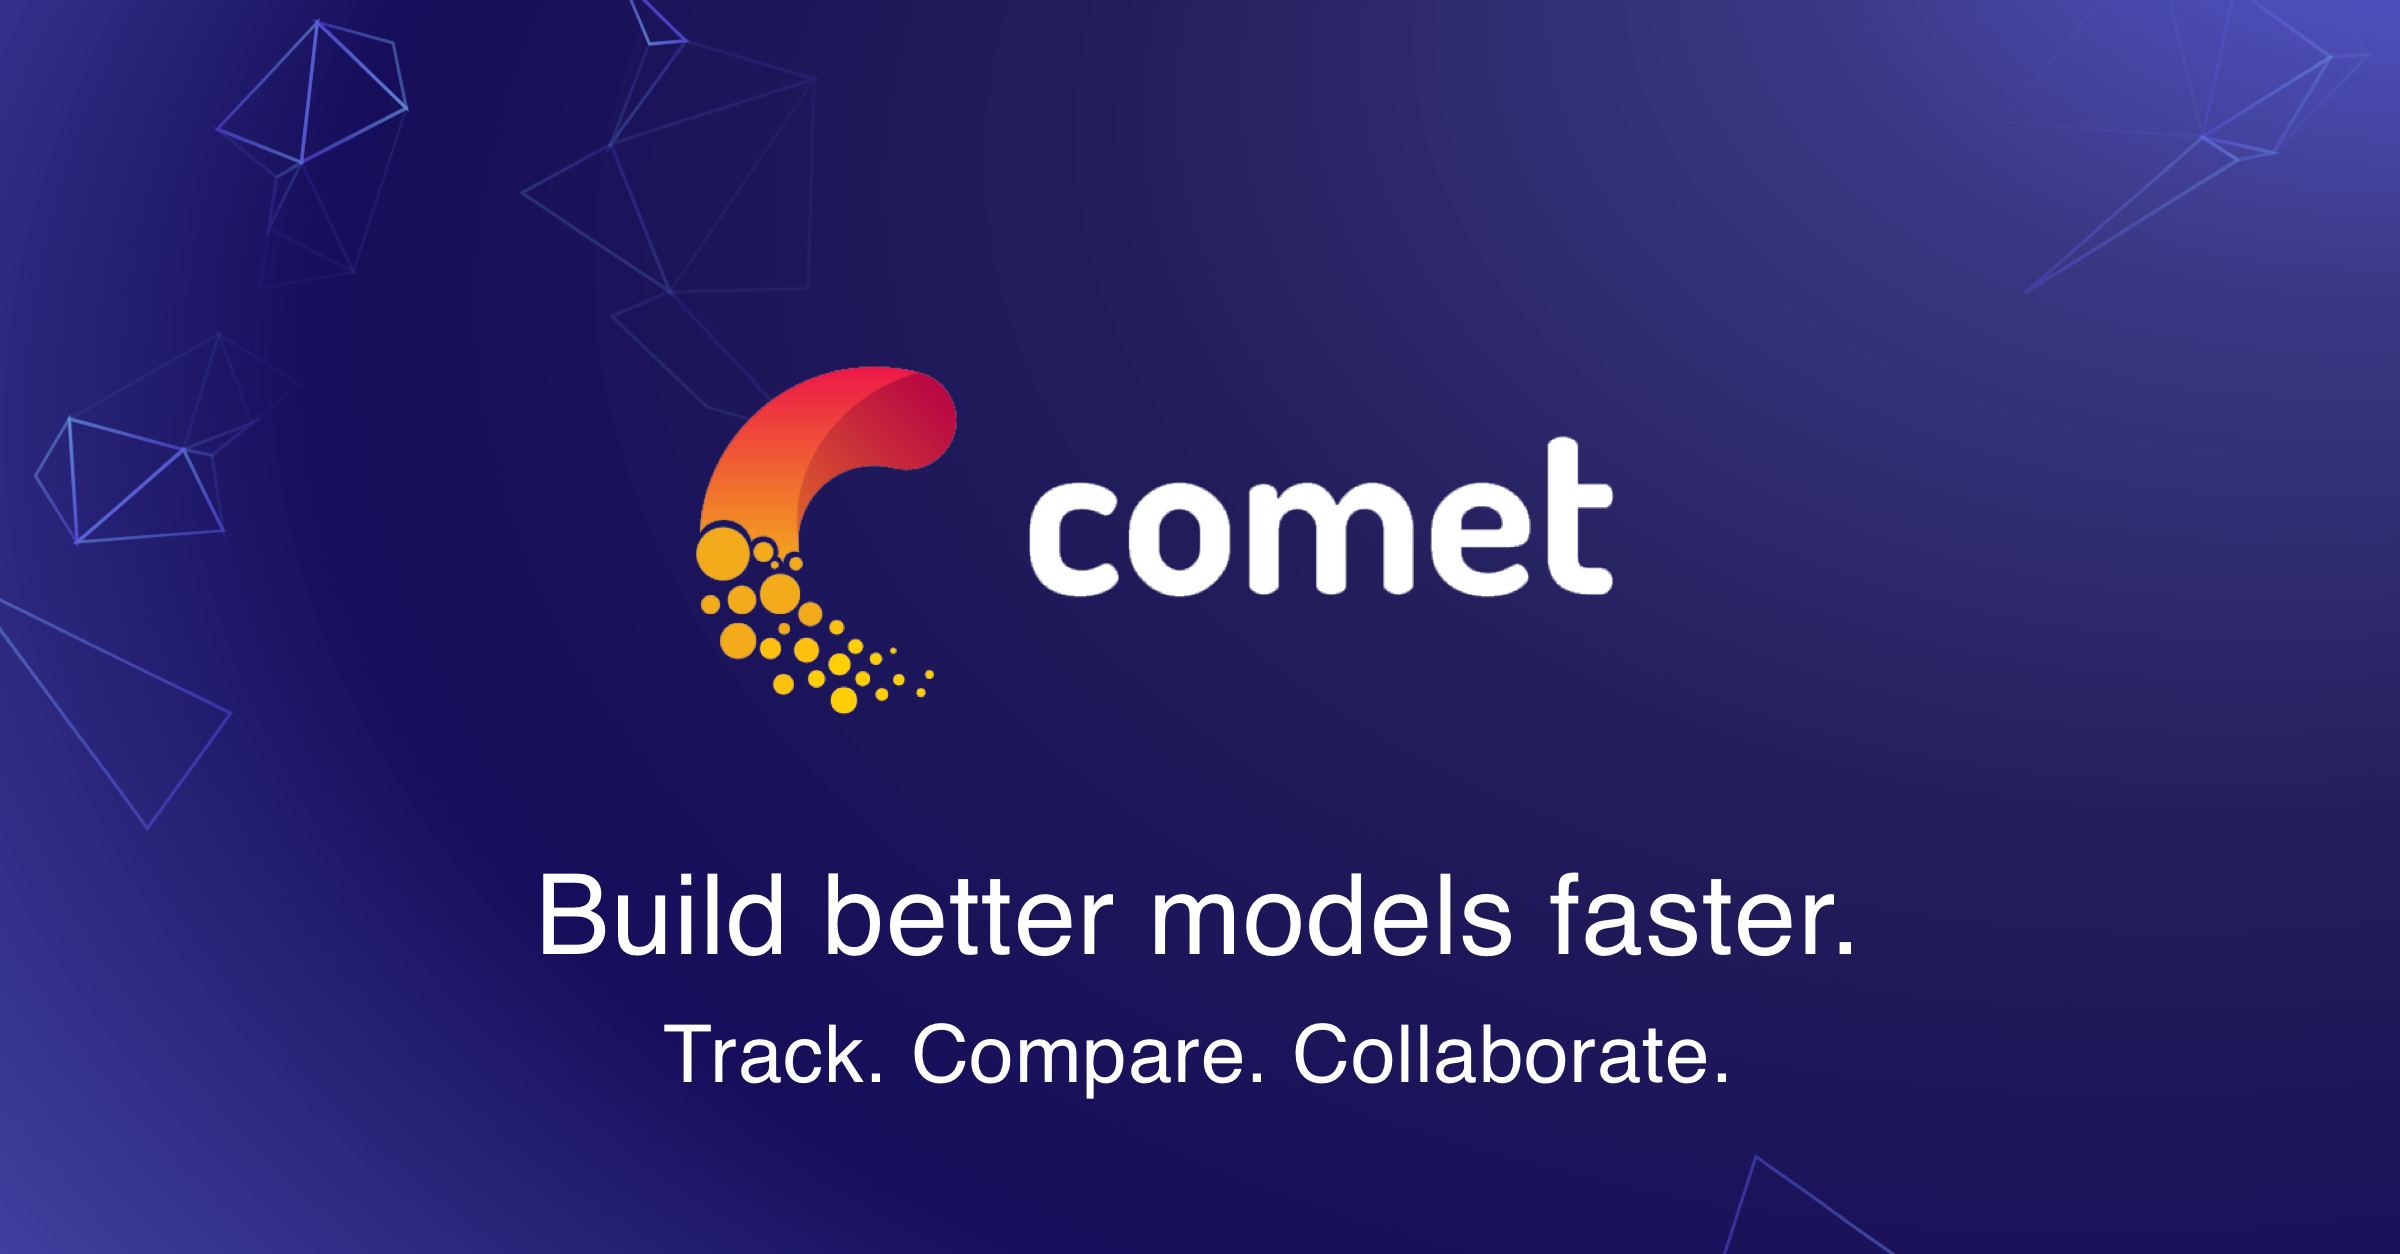

[Comet](https://www.comet.ml/site/data-scientists/?utm_campaign=tensorboardx-integration&utm_medium=colab) is an MLOps Platform that is designed to help Data Scientists and Teams build better models faster! Comet provides tooling to track, evaluate, Manage, and Monitor your traditional, deep learning, and LLM models in a single location.

# Comet Experiment Management

Experiment Management is used to track and compare traditional or deep learning training runs in a centralized location. The below walks through the process of logging a training run to Comet with just a few lines of code.

# Setup Comet

It take less than 30 seconds to get started with Comet. Start by installing the Comet SDK using `pip`

In [ ]:
%pip install --upgrade --quiet sagemaker comet_ml keras tensorflow

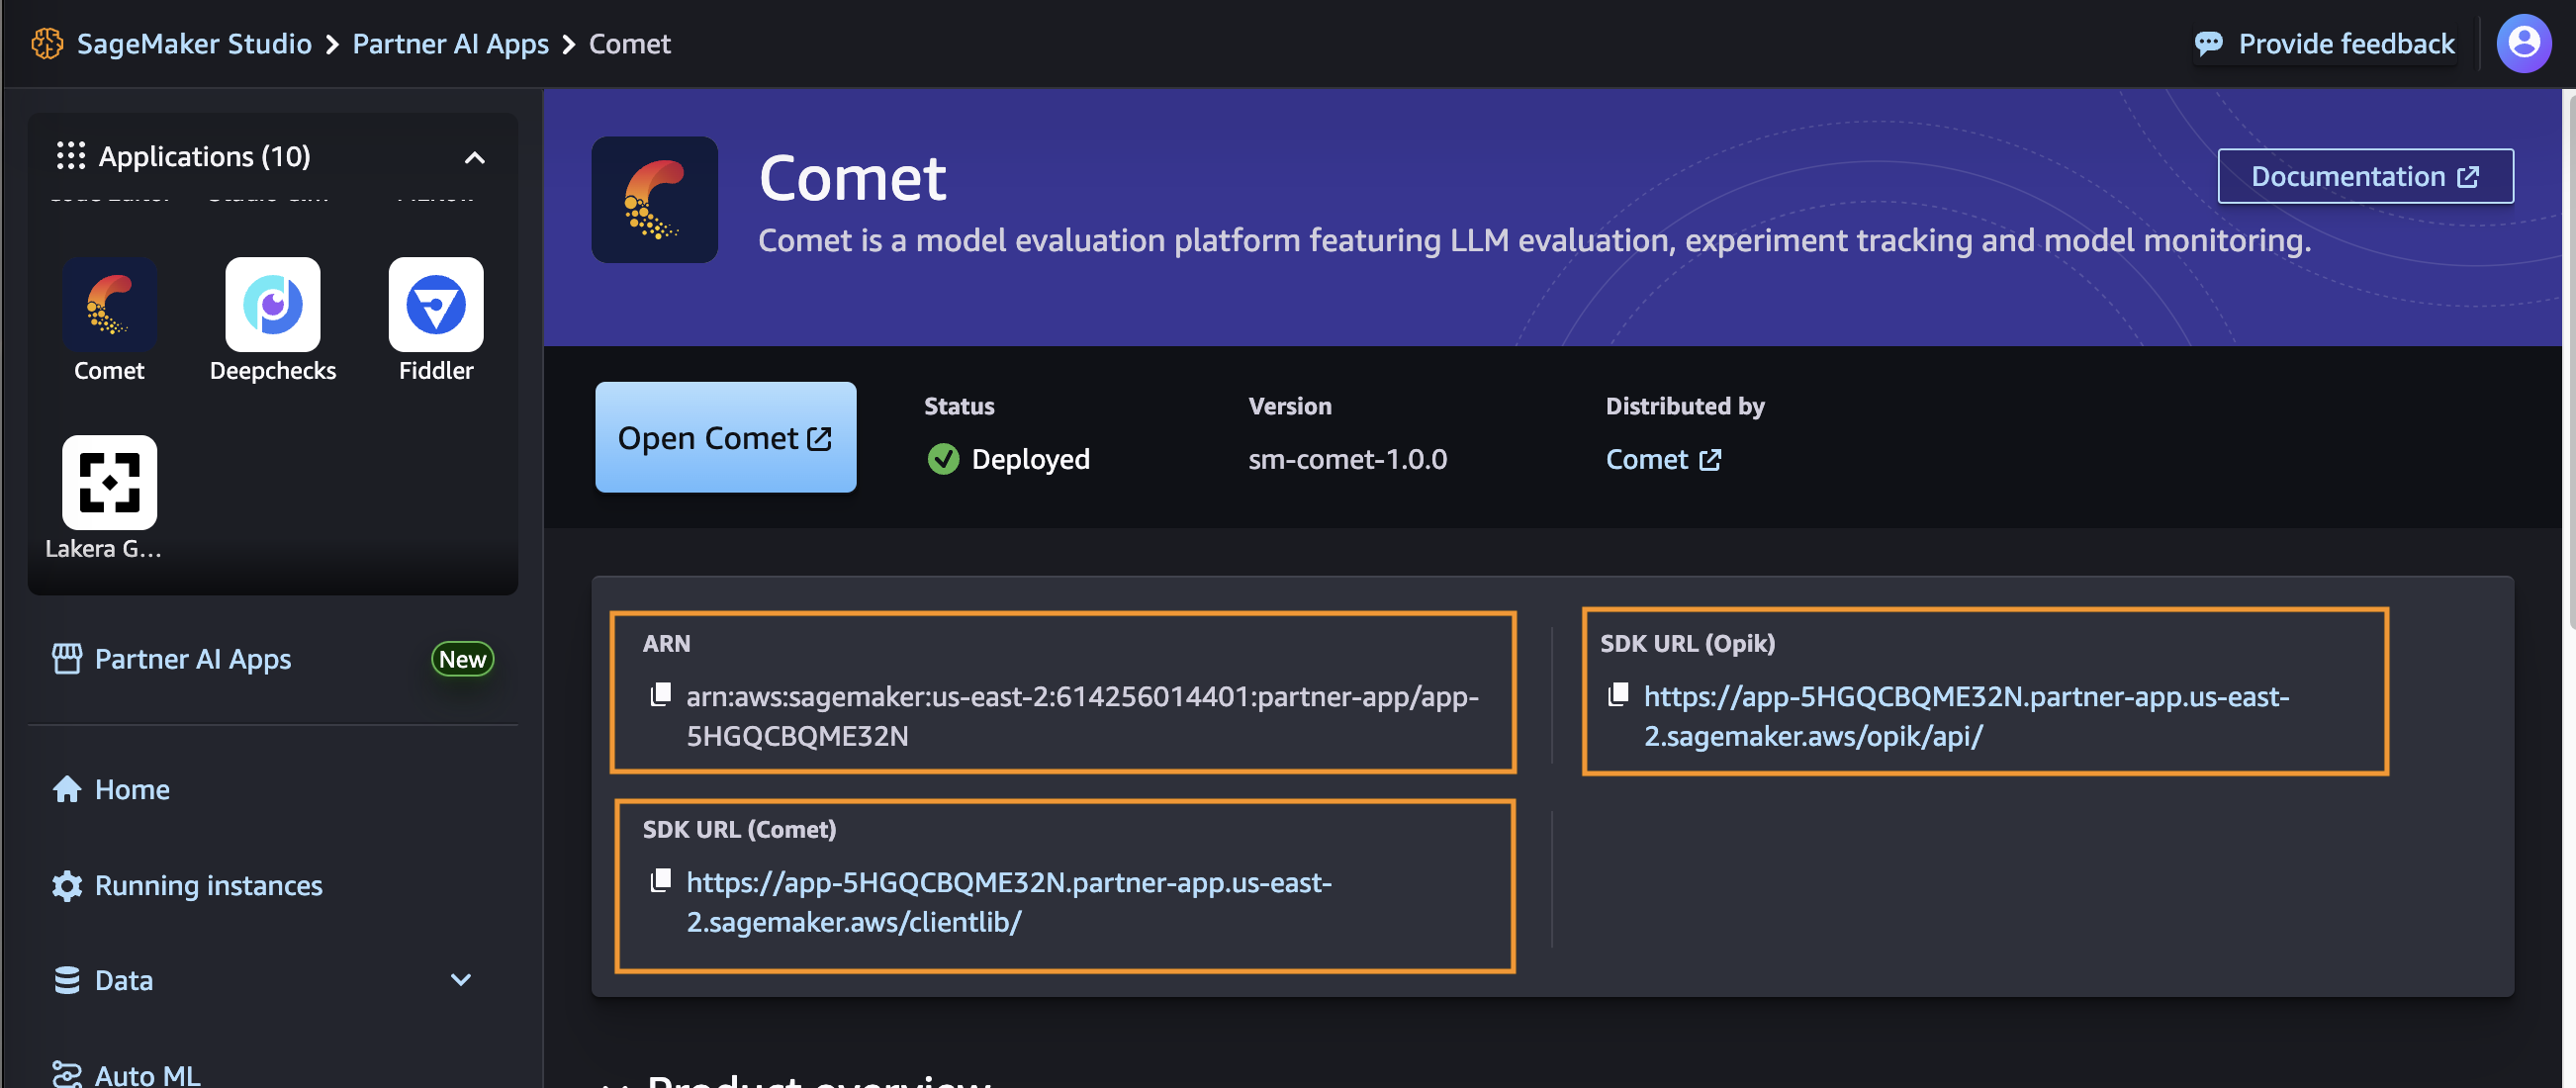

In [ ]:
# For SageMaker Studio -> Partner AI Apps -> Comet -> View Details
# For SageMaker Unified Studio -> Build -> Partner AI Apps -> Comet -> View Details
# Grab the SDK URL and ARN from Details page to use below

import os
os.environ["AWS_PARTNER_APP_AUTH"] = "true"
os.environ["AWS_PARTNER_APP_ARN"] = "" # View Details -> ARN
os.environ["COMET_API_KEY"] = "" # From Details Page, click Open Comet. In the top right corner, click on user -> API Key
# The SDK URL is embedded within the API key.  If you need to set it, uncomment the line below.
# os.environ["COMET_URL_OVERRIDE"] = ""

Next, import Comet into your training script or notebookand use `comet_ml.login()` to set our API Key. You can find your API key at Account Settings > API Keys.

We then instantiate a Comet Experiment object through `comet_ml.start()`, which will be automatically logged to throughout this notebook.

In [ ]:
import os
from requests import Session
from sagemaker import PartnerAppAuthProvider
import time


import comet_ml
from comet_ml import Artifact
project_name = f"comet-intro-{int(time.time())}"
print('Comet is configured with')
print(f'URL override: {comet_ml.get_config("comet.url_override")}')
print(f'App ARN: {os.environ["AWS_PARTNER_APP_ARN"]}')

print('Logging in...')
comet_ml.login()

api = comet_ml.API()
print('Getting account details...')
account_details = api.get_account_details()
workspace= account_details["defaultWorkspaceName"]
print(f'username: {account_details["userName"]}')
print(f'default workspace name: {account_details["defaultWorkspaceName"]}')

print(f'Creating a new experiment with: project_name={project_name} and workspace={workspace}')
experiment = comet_ml.start(
    project_name=project_name,
    workspace=workspace,
)

Comet integrates seamless with all of the popular Machine Learning Frameworks, We'll be using Keras for this Example, so that we can see demonstrate some of Comet's autologging features.    

# Setup, Define, and Train Model

We're going to train an image classifier on the CIFAR10 dataset. In this example we use Keras, but Comet integrates seamlessly with any of the common ML frameworks. Through integration with Keras, we will auto-log details about the training in real time without any instrumentation of the code below.



In [ ]:
import os
from comet_ml import Artifact, Experiment

import numpy as np

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
#import boto3

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

hyperparams = {
    'batch-size': 16,
    'epochs': 12,
    'filters-layergroup-1': 32,
    'filters-layergroup-2': 64,
    'filters-layergroup-3': 128,
    'dropout-layergroup-1': 0.3,
    'dropout-layergroup-2': 0.5,
    'dropout-layergroup-3': 0.5,
    'optimizer': 'adam', # adam adjusts the learning rate adaptively
    'loss': 'categorical_crossentropy'
}

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use some percentage of the dataset -----
dataset_percentage = 0.04

idx_train = np.arange(len(x_train))
idx_test = np.arange(len(x_test))

x_train = x_train[:int(dataset_percentage*len(idx_train))]
y_train = y_train[:int(dataset_percentage*len(idx_train))]
x_test = x_test[:int(dataset_percentage*len(idx_test))]
y_test = y_test[:int(dataset_percentage*len(idx_test))]
# ------------------------------------------

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Data Preprocessing

# Converting the pixels data to float type because to_categorical (one hot encoding) needs the data to be of type float by default.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Standardizing: convert all pixel values to values between 0 and 1. (255 is the total number of pixels an image can have)
x_train = x_train / 255
x_test = x_test / 255

# One hot encoding the target class (labels) because the loss function (categorical_crossentropy) used when compiling the model needs data to be one hot encoded.
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def build_model_graph(num_classes):
    model = Sequential()

    model.add(Conv2D(hyperparams['filters-layergroup-1'], (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-1'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-1']))

    model.add(Conv2D(hyperparams['filters-layergroup-2'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-2'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-2']))

    model.add(Conv2D(hyperparams['filters-layergroup-3'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-3'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-3']))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=['accuracy'])

    return model


model = build_model_graph(num_classes)

model.fit(x_train, y_train,
          batch_size=hyperparams['batch-size'],
          epochs=hyperparams['epochs'],
          shuffle=True,
          validation_data=(x_test, y_test))

Notice that so far we have not changed our training code to anything Comet specific. This is because Comet integrate with all of the common ML frameworks to auto-log metadata such as real time metrics during training, code, git info, installed packages, and system metrics.

You can view the results of your training run directly within this notebook, or in the Comet UI. Let's take a look at the metrics that have been auto-logged:

# Evaluating the Model

Next we'll use a Confusion Matrix to evaluate our model predictions. The Comet Confusion Matrix is interactive, and makes it easy to view misclassified examples in the dataset.

In [ ]:
def test_index_to_example(index):
    img = x_test[index]
    data = experiment.log_image(img, name="test_%d.png" % index)
    return {"sample": str(index), "assetId": data["imageId"]}

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
experiment.log_confusion_matrix(y_test, y_pred,
                                labels=class_names,
                                max_examples_per_cell=6,
                                index_to_example_function=test_index_to_example)

Let's take a look at Confusion Matrix. You can click on the cells in the Matrix to display misclassified examples.

# Log Additional Metadata to Comet

Comet supports logging a wide selection of data types in order to properly track all use cases. This includes (but is not limited to) versioned dataset artifacts, dataframes, audio files, text samples, HTML, models, system metrics, and more.

See our [documentation](https://www.comet.ml/docs/v2/api-and-sdk/python-sdk/reference/Experiment/) for all methods that can be used for additional logging. Note that all method calls are in the format of experiment.command.

Below are a few examples of logging additional assets and metadata:


In [ ]:
# Log a pointer to your trained model
experiment.log_remote_model(model_name='cifar10-neural-net',
                                uri='s3://sagemaker-eu-north-1-rodrigo/models/cifar10/cifar10-nn-1500.h5')

# log a custom metric
experiment.log_metric('custom_metric', 0.98)

#Add a tag to the model
experiment.add_tag('demo')

# Log other key-value pairs
experiment.log_other('run_id', 1)

# Log a Remote Dataset Artifact
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

from comet_ml import Artifact
artifact = Artifact(
        name="cifar-demo-dataset",
        artifact_type="dataset",
        aliases=["raw"],
        version_tags= ["remote"],
        metadata={"date": date}
    )


artifact.add_remote(uri="s3://comet-ml-demo/data/my-data.csv", metadata={"date": date})

experiment.log_artifact(artifact)

In [ ]:
experiment.end()

##  Visualize Cross-Project Results in the Project View

Once you have logged multiple expeirments, you can then compare across those experiments with Comet's customizable project Views.

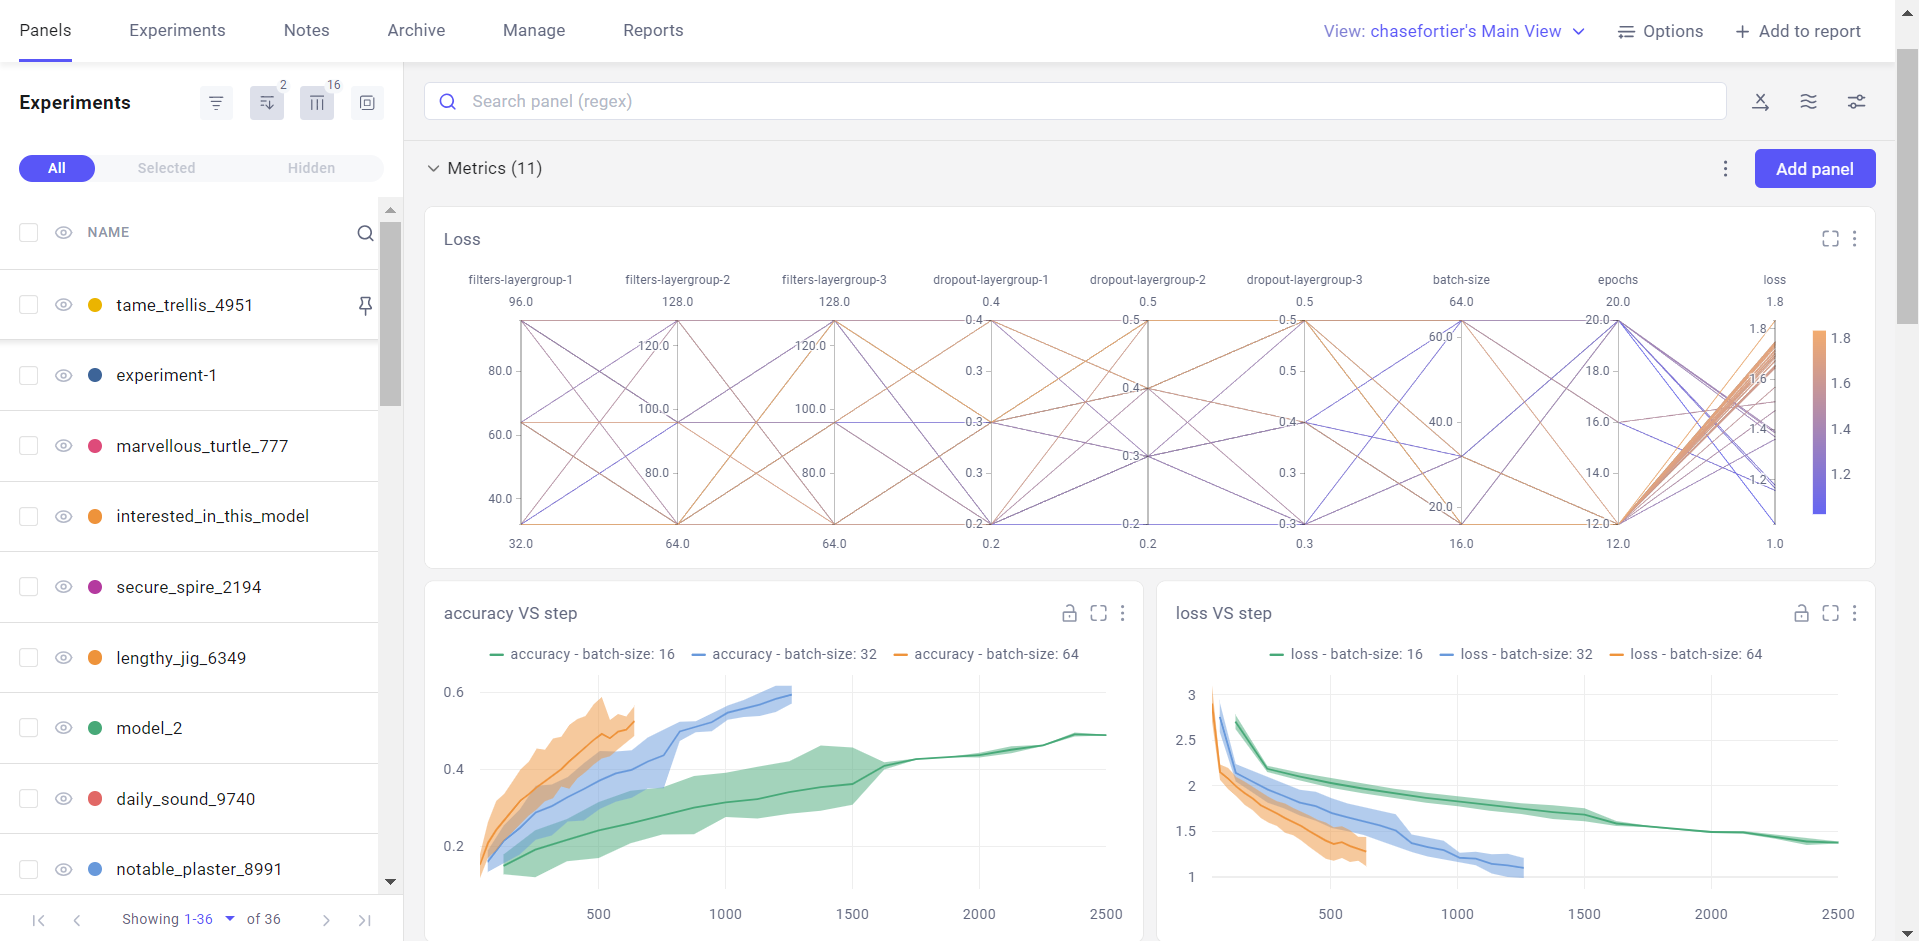

This also includes support for completely custom visualizations built with your own Python code! For example, below we have created a custom cost tracker based on the runtime of all experiments within your project:
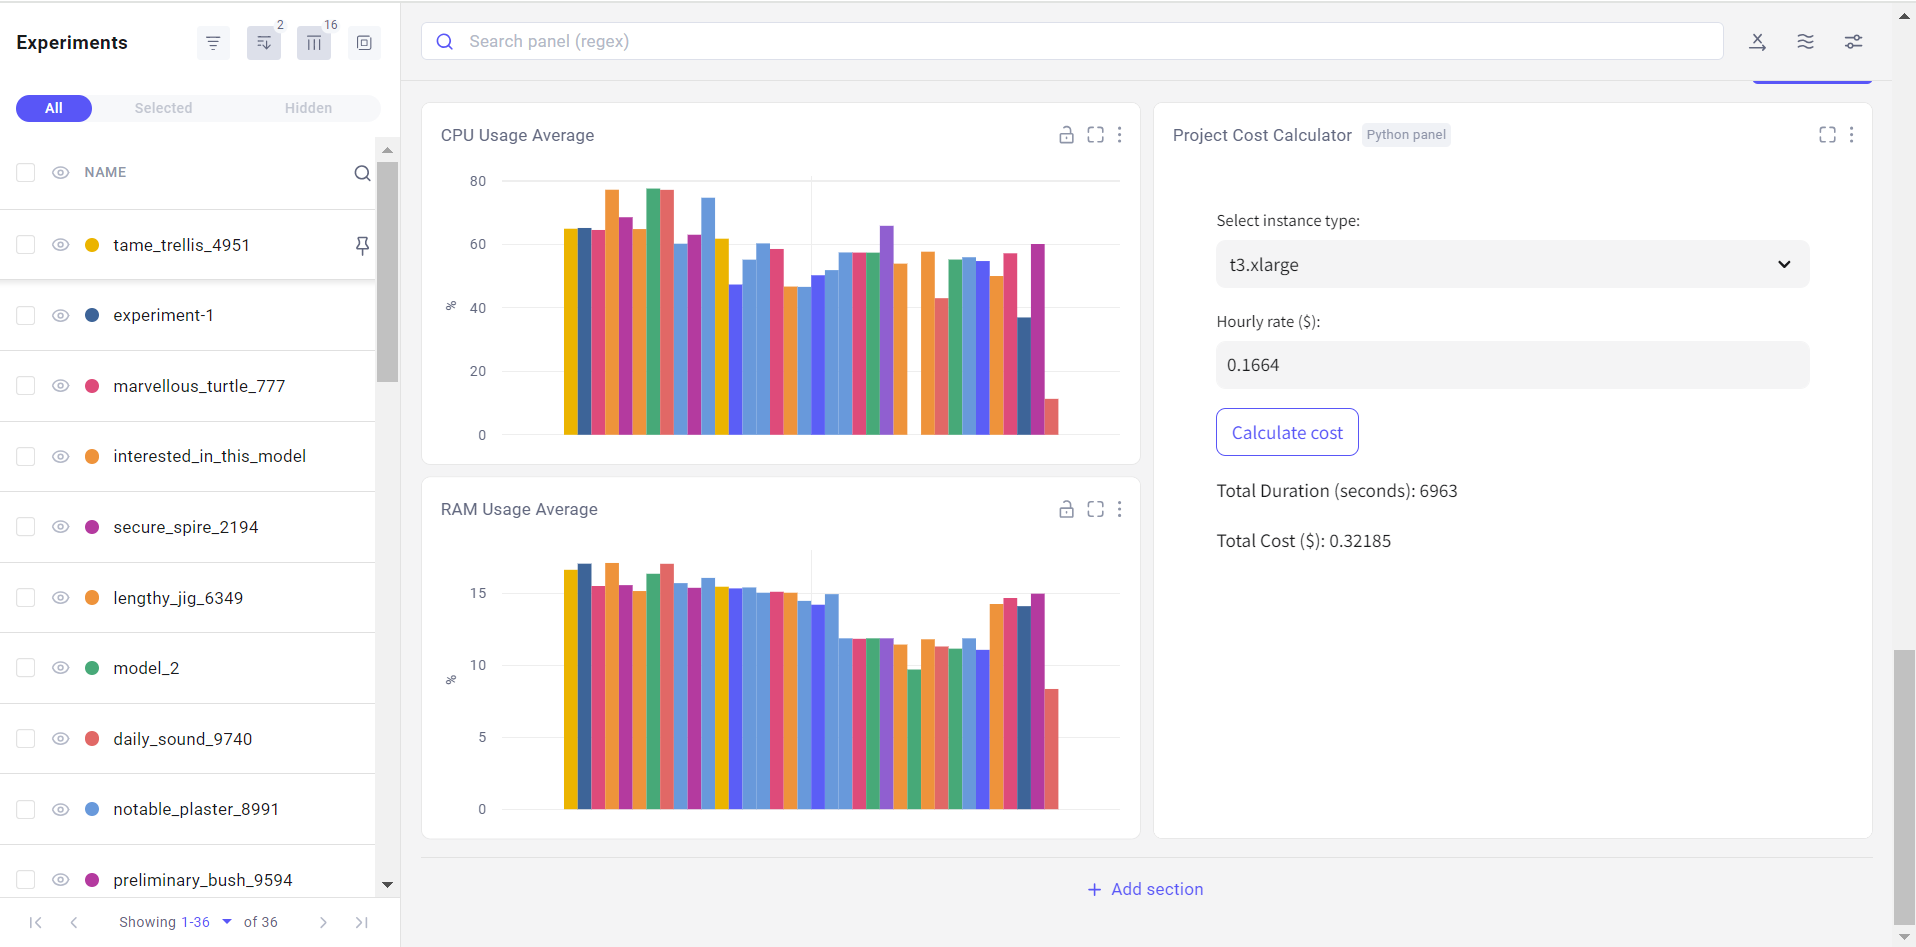